In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_roc, plot_cumulative_gain
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

In [2]:
data=pd.read_csv('D:/MS//sem2/ml/proj/online_shoppers_intention.csv')

In [3]:
def categorical_analysis(var, **kwargs):
    fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].set_title(f'Variable {var}')
    sns.countplot(data=data, x=var, **kwargs, ax=axes[0])
    crossed=pd.crosstab(data[var], data.Revenue, normalize=0).unstack().reset_index().rename(columns={0:'Percentage'})
    crossed.loc[crossed.Revenue==False,'Percentage']=1
    sns.barplot(data=crossed, x=var, y='Percentage', hue='Revenue', ax=axes[1], **kwargs, dodge=False)
    axes[1].set_title(f'Revenue ~ {var}')
    plt.suptitle(f'Variable {var}')
    plt.show()   
    print('\n CHI SQUARE TEST \n')
    p_value=chi2_contingency(pd.crosstab(data[var], data.Revenue))[1]
    if p_value>0.05:
        print(f'The p_value is {p_value} and therefore we have to accept the null hypothesis that there is no significant relationship between {var} and Revenue')
    else:
        print(f'The p_value is {p_value} and therefore we can reject the null hypothesis that there is no significant relationship between {var} and Revenue')
        
        
def continuous_analysis(var,data=data, **kwargs):
    fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].set_title(f'Variable {var}')
    sns.histplot(data, x=var, **kwargs, ax=axes[0], bins=30, hue='Revenue', multiple='stack')
    sns.boxplot(data=data,y=var,x='Revenue', hue='Revenue' , ax=axes[1], **kwargs)
    plt.title(f'Revenue ~ {var}')
    plt.suptitle(f'Variable {var}')
    plt.show()
    print(f'\n The maximum value is {data[var].max()} \n The minimum value is {data[var].min()} ')
    

In [4]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
#Data Structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [6]:
data=data.dropna().copy()

In [7]:
#Let´s convert the categorical data to categorical data types.

cat=data.columns[10:]

data[cat]=data[cat].astype('category')

In [8]:
#inicial statistical analysis -numeric variables

data.describe() 

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


In [9]:
#Categorical Variables
data.describe(include='category')

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330,12330,12330,12330,12330,12330,12330,12330
unique,10,8,13,9,20,3,2,2
top,May,2,2,1,2,Returning_Visitor,False,False
freq,3364,6601,7961,4780,3913,10551,9462,10422


In [10]:
data=data.drop(data[(data.Administrative_Duration<0)&(data.Informational_Duration<0)&(data.ProductRelated_Duration<0)].index).reset_index(drop=True)

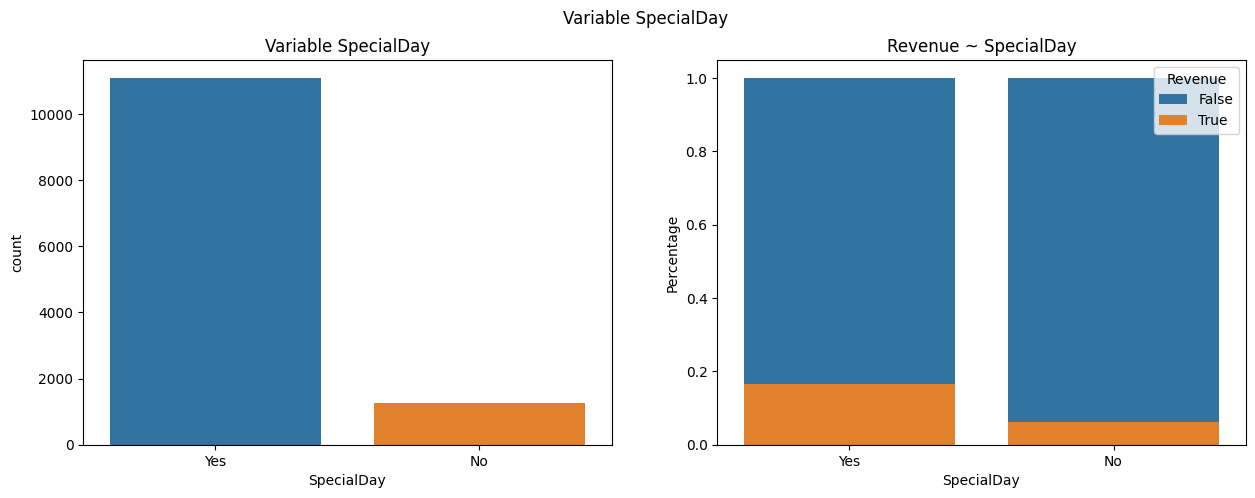


 CHI SQUARE TEST 

The p_value is 1.0317417596405984e-21 and therefore we can reject the null hypothesis that there is no significant relationship between SpecialDay and Revenue


In [11]:
#This variable seems to be a good candidate to categoricals. It has only 6 different values (We have checked it at the beginning).
#Let's split it into two categories: 'yes' for 'Special day' days and 'no' for the others(0.2-> 1)

data['SpecialDay']=pd.cut(data['SpecialDay'], bins=[-1,0.1,1.1], labels=['Yes','No'])

categorical_analysis('SpecialDay')

C:\Users\raghu\AppData\Local\Temp\ipykernel_58804\3998097960.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(data.corr()))
C:\Users\raghu\AppData\Local\Temp\ipykernel_58804\3998097960.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, mask=mask, cmap='Blues', xticklabels=data.select_dtypes(exclude='category').columns[:-1]\


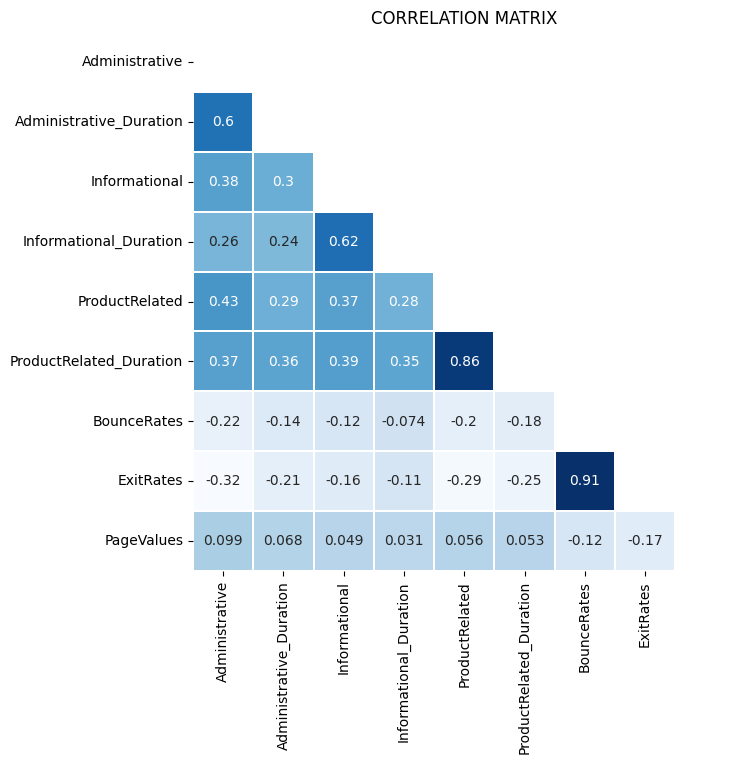

In [12]:
#Conclusions -we have much more observations of special days. Special days usually have higher conversion and it is
#statistically significant.

#Let´s examine now the correlation between the numerical variables:

mask = np.triu(np.ones_like(data.corr()))
plt.figure(figsize=(7,7))
sns.heatmap(data.corr(), annot=True, mask=mask, cmap='Blues', xticklabels=data.select_dtypes(exclude='category').columns[:-1]\
           ,yticklabels='auto', linewidths=.1, cbar=False)
np.fill_diagonal(mask, True)
plt.title('CORRELATION MATRIX')
plt.show()

In [13]:
numeric=data.select_dtypes(exclude='category')

VIF=pd.DataFrame()
VIF['variables']=numeric.columns
VIF['values']=[variance_inflation_factor(numeric.values, column) for column in range(len(numeric.columns))]
VIF

,variables,values
0,Administrative,2.650789
1,Administrative_Duration,2.041793
2,Informational,2.113500
3,Informational_Duration,1.777152
4,ProductRelated,6.309248
5,ProductRelated_Duration,6.007085
6,BounceRates,5.483943
7,ExitRates,5.715925
8,PageValues,1.077639


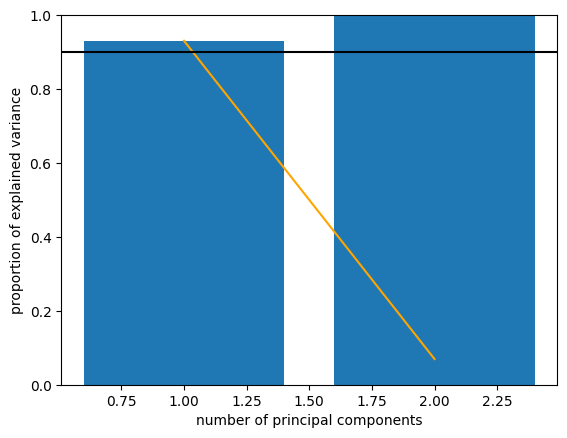

In [14]:
scaler=StandardScaler()
norm=pd.DataFrame()
norm[['ProductRelated','ProductRelated_Duration','BounceRates','ExitRates']]\
=scaler.fit_transform(data[['ProductRelated','ProductRelated_Duration','BounceRates','ExitRates']])

pca=PCA()
pca.fit(norm[['ProductRelated','ProductRelated_Duration',]])


#Representation of the accumulated explained variance.

plt.plot(range(1,3), pca.explained_variance_ratio_, c='orange')
plt.bar(range(1,3), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(f'number of principal components')
plt.ylabel(f'proportion of explained variance')
plt.ylim(0,1)
plt.axhline(0.9, c='black')
plt.show()

In [15]:
#We see that with one variable we can explain more than 90% of the variance of the two original variables.


pca=PCA(n_components=1)
norm['Product_Related_PCA']=pca.fit_transform(norm[['ProductRelated','ProductRelated_Duration']])

norm=norm.drop(['ProductRelated','ProductRelated_Duration'],axis=1)

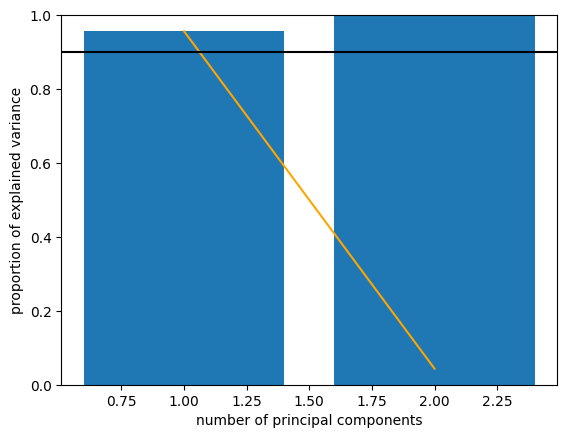

In [16]:
pca2=PCA()
pca2.fit(norm[['BounceRates','ExitRates']])

#Representation of the accumulated explained variance.

plt.plot(range(1,3), pca2.explained_variance_ratio_, c='orange')
plt.bar(range(1,3), np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel(f'number of principal components')
plt.ylabel(f'proportion of explained variance')
plt.ylim(0,1)
plt.axhline(0.9, c='black')
plt.show()

In [17]:
#We see that with one variable we can explain more than 95% of the variance of the two original variables.

pca2=PCA(n_components=1)

norm['Bounce_Exit_PCA']=pca2.fit_transform(norm[['BounceRates','ExitRates']])

norm=norm.drop(['BounceRates','ExitRates'],axis=1)

In [18]:
#Unite the new variables with other continuous ones and scale.

numeric=numeric.drop(['ProductRelated','ProductRelated_Duration','BounceRates','ExitRates'],axis=1)
numeric[['Product_Related_PCA','Bounce_Exit_PCA' ]]=norm

#To improve the results, it will be necessary to transform the data so that they have a distribution that is as close as possible to a
#normal. Although our data is very problematic in this regard (lots of '0' values ​​and also outliers).
#to a normal one but we will still improve the predictive power of algorithms such as regression. In this case we will use the 'Yeo-Johnson' method.
#Transformation also helps with outliers.

columns=numeric.columns

trans=PowerTransformer(standardize=False)
numeric_trans=trans.fit_transform(numeric)

#We normalize between 0 and 1 (we obtain better results in our particular case with the data we have)

minmax=MinMaxScaler()
numeric_scaled=pd.DataFrame(minmax.fit_transform(numeric_trans), columns=columns)

In [19]:
#One-Hot Encoding

cat=pd.get_dummies(data.select_dtypes(include='category'), drop_first=True)

In [34]:
df=pd.concat([cat, numeric_scaled], axis=1)

y=df.Revenue_True
X=df.drop('Revenue_True', axis=1)

X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.8, random_state=1)

In [21]:
#Let's start adjusting models. We will start with a linear model (as stipulated in the exercise) of logistic regression,
#calibrate the best hyperparameters through exhaustive search with GridSearch. GridSearch will evaluate each combination
#with cross-validation and it will return the best parameters and their respective cross-validation score (mean of Folds scores)

regr=LogisticRegression()

params={'C':[0.8,0.9,1],'class_weight':['balanced'], 'max_iter':[100,200]}

model_log=GridSearchCV(regr,params,cv=6, scoring='roc_auc') #usamos el StratiifiedKFold (por defecto)

model_log.fit(X_train, y_train)
print(f'The best model parameters are: {model_log.best_params_} \n')

print(f'Mean Cross Validation Roc AUC score of the logistic regression is {model_log.best_score_}')

The best model parameters are: {'C': 0.8, 'class_weight': 'balanced', 'max_iter': 100} 

Mean Cross Validation Roc AUC score of the logistic regression is 0.9160022944198984


In [22]:
forest=RandomForestClassifier(n_jobs=-1, n_estimators=200)

params={'max_depth':range(6,14), 'min_samples_leaf':[2,3,4]}

model_forest=GridSearchCV(forest, params, cv=6)

#Random Forest does not require as much data preparation as linear models. You only need numerical data (categorical variables
# have to be encoded). Therefore we will try to fit the model with 'almost original' data - from before dimensional reduction.
#Later we will also adjust with the same regression data and see where we had better performance.

data=data.drop('Revenue', axis=1)
categ=pd.DataFrame()

#We encode the categoricals differently (similar to LabelEncoder())

for i in data.select_dtypes(include='category').columns:
    categ[i]=pd.factorize(data[i])[0]

df=pd.concat([categ,data.select_dtypes(exclude='category')], axis=1)

X_train2, X_test2, y_train2, y_test2=train_test_split(df, y, train_size=0.8, random_state=1)



model_forest.fit(X_train2, y_train2)

print(f'The best model parameters are: {model_forest.best_params_} \n')

print(f'Mean Cross Validation Roc AUC score of the Random Forest Algorithm is {model_forest.best_score_}')

The best model parameters are: {'max_depth': 12, 'min_samples_leaf': 3} 

Mean Cross Validation Roc AUC score of the Random Forest Algorithm is 0.9034874290348744


In [23]:
#We will try with the fully transformed data (same input as in logistic regression)

forest2=RandomForestClassifier(n_jobs=-1, n_estimators=200)

params={'max_depth':range(6,14), 'min_samples_leaf':[2,3,4]}

model_forest=GridSearchCV(forest, params, cv=6)

model_forest.fit(X_train, y_train)

print(f'The best model parameters are: {model_forest.best_params_} \n')

print(f'Mean Cross Validation Roc AUC score of the Random Forest Algorithm is {model_forest.best_score_}')

The best model parameters are: {'max_depth': 12, 'min_samples_leaf': 2} 

Mean Cross Validation Roc AUC score of the Random Forest Algorithm is 0.9013584752635849


In [24]:
#We can see the cross-validation result obtained for Random Forest is almost similar for"original" and transformed data.

In [25]:
?model.add

Object `model.add` not found.


In [26]:
X_train.head()

,SpecialDay_No,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,...,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Administrative,Administrative_Duration,Informational,Informational_Duration,PageValues,Product_Related_PCA,Bounce_Exit_PCA
3339,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0.000000,0.000000,0.0,0.0,0.0,0.077261,0.579880
10953,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0.000000,0.000000,0.0,0.0,0.0,0.012444,1.000000
8536,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0.000000,0.000000,0.0,0.0,0.0,0.012444,1.000000
7766,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0.771712,0.676857,0.0,0.0,0.0,0.166156,0.546529
8280,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0.734741,0.580542,0.0,0.0,0.0,0.240953,0.438063


In [27]:

from tensorflow.keras import regularizers
from keras.regularizers import l2
#Construction of the model:

def deep_model_compile(): 
    
    model=Sequential()
    model.add(Dense(120, activation='relu',input_shape=(66,),kernel_regularizer=l2(0.03)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(120, activation='relu'))
    model.add(Dense(33, activation='relu'))
    model.add(Dropout(0.4) )
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics='AUC')
    model.summary()
    return model

In [28]:
model1=deep_model_compile()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               8040      
                                                                 
 dense_1 (Dense)             (None, 256)               30976     
                                                                 
 dense_2 (Dense)             (None, 120)               30840     
                                                                 
 dense_3 (Dense)             (None, 33)                3993      
                                                                 
 dropout (Dropout)           (None, 33)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 34        
                                                                 
Total params: 73,883
Trainable params: 73,883
Non-traina

In [29]:
store=model1.fit(X_train, y_train,epochs=30,validation_split=0.1,verbose=1)

Epoch 1/30
278/278 [==============================] - 11s 23ms/step - loss: 0.8586 - auc: 0.8596 - val_loss: 0.3241 - val_auc: 0.9181
Epoch 2/30
278/278 [==============================] - 7s 24ms/step - loss: 0.2911 - auc: 0.9085 - val_loss: 0.2795 - val_auc: 0.9253
Epoch 3/30
278/278 [==============================] - 5s 19ms/step - loss: 0.2706 - auc: 0.9156 - val_loss: 0.2784 - val_auc: 0.9236
Epoch 4/30
278/278 [==============================] - 5s 19ms/step - loss: 0.2684 - auc: 0.9145 - val_loss: 0.2741 - val_auc: 0.9271
Epoch 5/30
278/278 [==============================] - 5s 18ms/step - loss: 0.2629 - auc: 0.9180 - val_loss: 0.2761 - val_auc: 0.9238
Epoch 6/30
278/278 [==============================] - 5s 20ms/step - loss: 0.2581 - auc: 0.9214 - val_loss: 0.2696 - val_auc: 0.9278
Epoch 7/30
278/278 [==============================] - 5s 19ms/step - loss: 0.2599 - auc: 0.9193 - val_loss: 0.2625 - val_auc: 0.9298
Epoch 8/30
278/278 [==============================] - 5s 19ms/step -

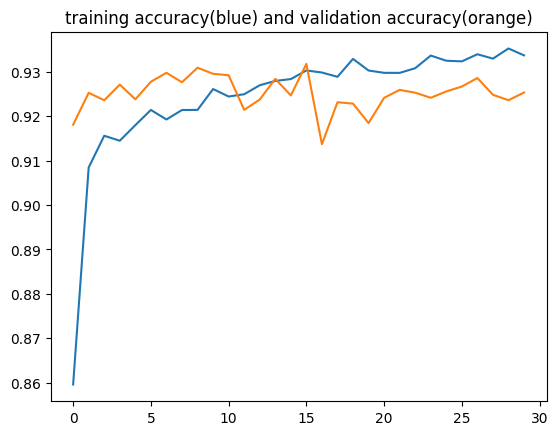

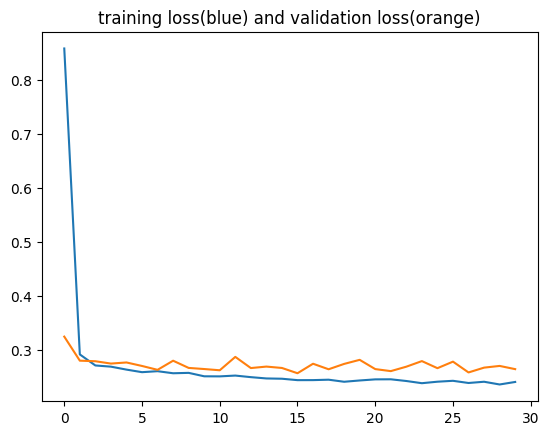

In [30]:
#Best Parameters]
auc=store.history['auc']
val_auc=store.history['val_auc']
e=np.arange(0,30)

loss=store.history['loss']
val_loss=store.history['val_loss']

import matplotlib.pyplot as plt
plt.plot(e,auc)
plt.plot(e,val_auc)
plt.title('training accuracy(blue) and validation accuracy(orange)')
plt.show()

plt.plot(e,loss)
plt.plot(e,val_loss)
plt.title('training loss(blue) and validation loss(orange)')
plt.show()

### Clustering Analysis ###

In [41]:
# Imputing Missing Values with 0
data.fillna(0, inplace = True)

#checking the no. of null values after imputing
data.isnull().sum().sum()

0

### Administrative Duration vs Bounce Rates ###

In [47]:
data.iloc[:,6]


0        0.200000
1        0.000000
2        0.200000
3        0.050000
4        0.020000
           ...   
12325    0.007143
12326    0.000000
12327    0.083333
12328    0.000000
12329    0.000000
Name: BounceRates, Length: 12330, dtype: float64

In [48]:
x = data.iloc[:, [1, 6]].values

In [49]:
from sklearn.cluster import KMeans


C:\Users\raghu\anaconda3\envs\cv1\lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


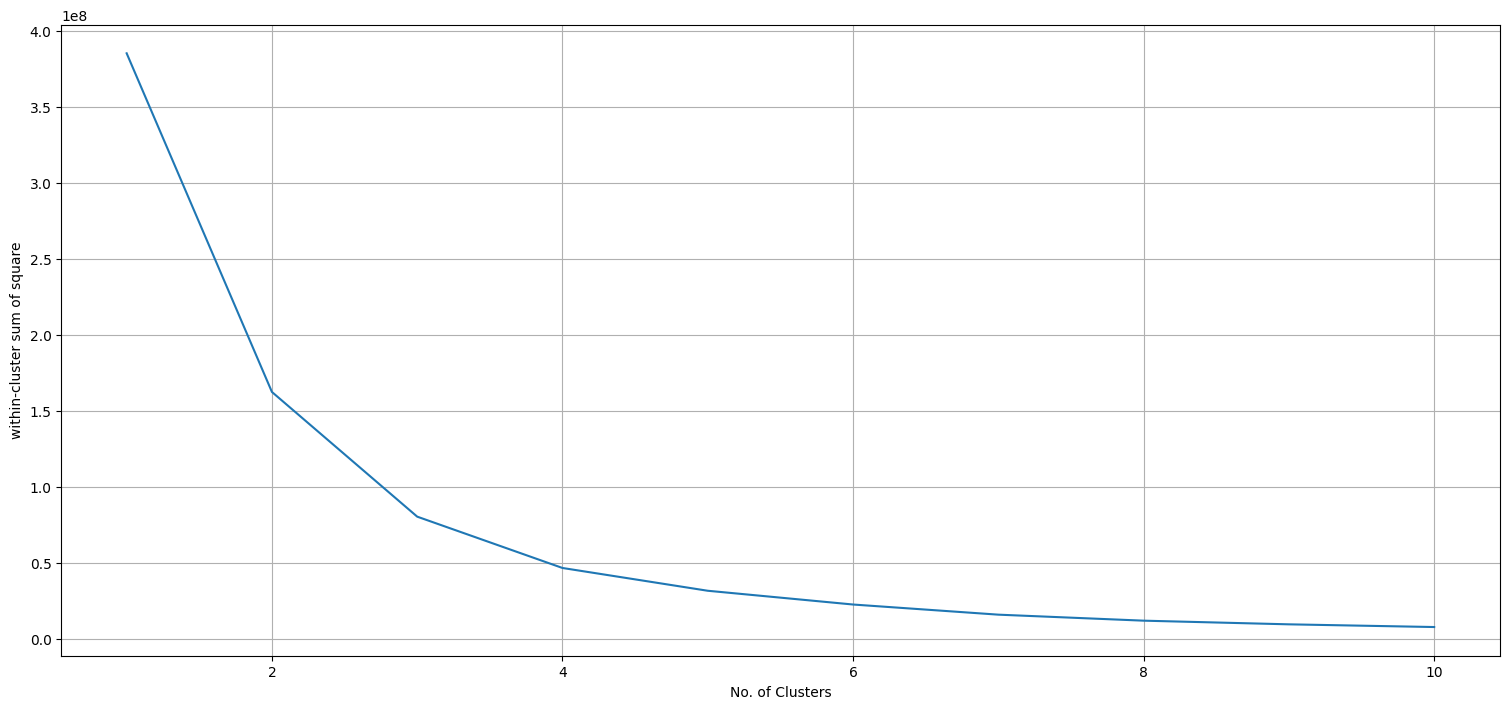

In [50]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i,
               init = 'k-means++',
               max_iter = 200,
               n_init = 10, 
               random_state = 0,
               algorithm = 'elkan',
               tol = 0.001)
    km.fit(x)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(1, 11), wcss)
plt.grid()
plt.tight_layout()
plt.xlabel('No. of Clusters')
plt.ylabel('within-cluster sum of square')
plt.show()

from this cluster plot is we could see the elbow point at k=3 which represent the number of optimal clusters in this particular analysis(Administration_duration vs Revenue)

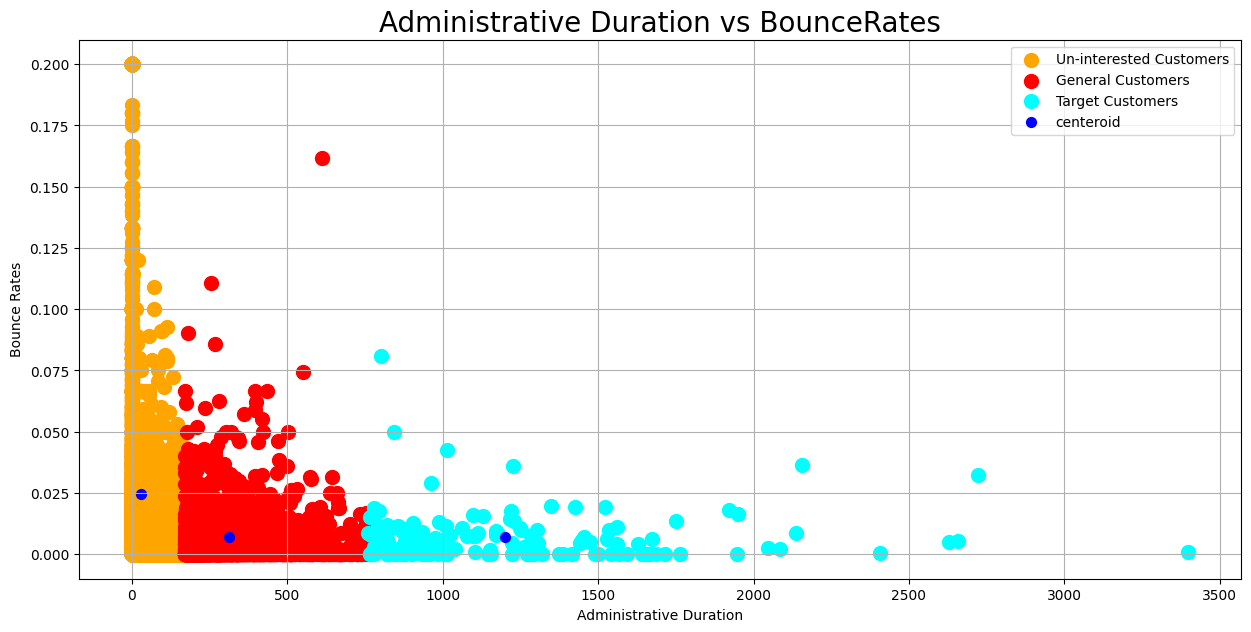

In [51]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 200, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)

plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 100, c = 'orange', label = 'Un-interested Customers')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 100, c = 'red', label = 'General Customers')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 100, c = 'cyan', label = 'Target Customers')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s = 50, c = 'blue', label = 'centeroid')

plt.title('Administrative Duration vs BounceRates', fontsize = 20)
plt.grid()
plt.xlabel('Administrative Duration')
plt.ylabel('Bounce Rates')
plt.legend()
plt.show()

From this graph we can infer that as the administrative duration increases the bounce rate also decreases(meaning they will navigate away from the website just after navigating 1 page of the website)

Theses 3 optimal clusters explains about the type of customers who spend shortest administration duration and have high chance of navigating away from a website


### Informational Duration vs Bounce Rates ###

C:\Users\raghu\anaconda3\envs\cv1\lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


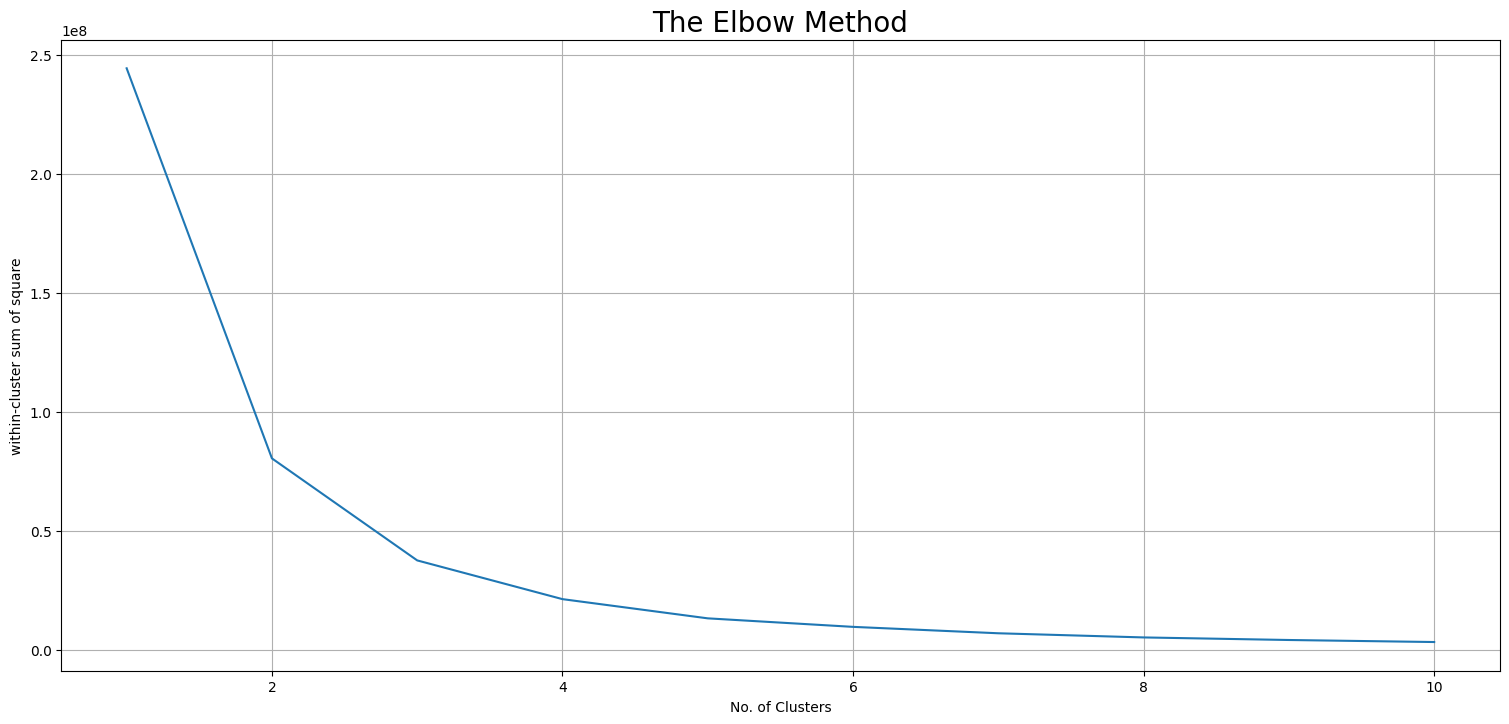

In [52]:
x = data.iloc[:, [3, 6]].values

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 200,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    km.fit(x)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(1, 11), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('within-cluster sum of square')
plt.show()

the elbow point(max bend) is 2.
The optimal number of clusters for these 2 feature variable comparison is 2

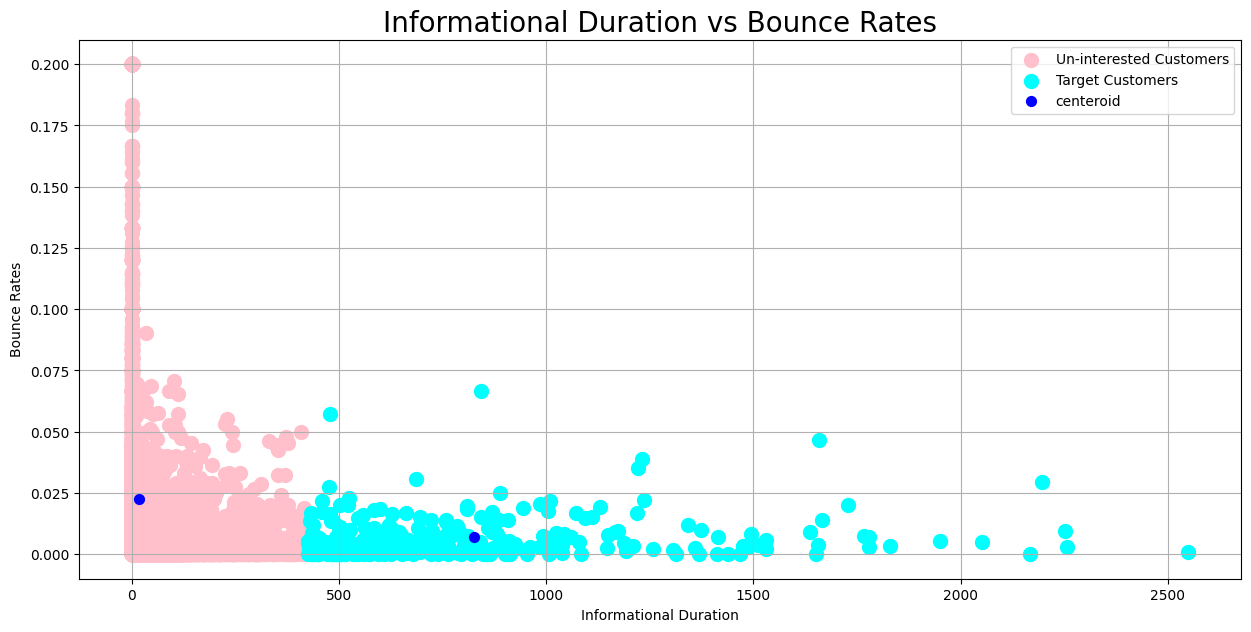

In [53]:
km = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 200, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)

plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 100, c = 'pink', label = 'Un-interested Customers')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 100, c = 'cyan', label = 'Target Customers')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.title('Informational Duration vs Bounce Rates', fontsize = 20)
plt.grid()
plt.xlabel('Informational Duration')
plt.ylabel('Bounce Rates')
plt.legend()
plt.show()


This analysis says that customers who spent a long duration on the website is less likely to bouce to the other website.
group 1(un-interested customers) - short informational duration has high chances of navigating away
group 2(interested customers) - high informational duration but has very less chance of navigating away.